In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn import metrics

# from mlxtend.plotting import plot_decision_regions
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from ast import literal_eval

import warnings
import numpy as np
from collections import OrderedDict

from lob_data_utils import lob, db_result, model, roc_results
from lob_data_utils.svm_calculation import lob_svm
import os


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

/home/vevurka/.conda/envs/python36/lib/python3.6/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [2]:
data_length = 15000
rs_params = [(0.1, 1.0), (1.0, 0.1), (1.0, 1.0), (0.1, 0.1)]
stocks = list(roc_results.result_cv_15000.keys())
data_dir = 'res_pca_gdf3_15000'

In [3]:
def get_mean_scores(scores: dict) -> dict:
    mean_scores = {}
    for k, v in scores.items():
        mean_scores[k] = np.mean(v)
    return mean_scores

def get_score_for_clf(clf, df_test):
    x_test = df_test[['queue_imbalance']]
    y_test = df_test['mid_price_indicator'].values
    return model.test_model(clf, x_test, y_test)

def get_logistic_regression(stock, data_length):
    df, df_test = lob.load_prepared_data(
        stock, data_dir='../gaussian_filter/data', cv=False, length=data_length)
    clf = LogisticRegression()
    train_x = df[['queue_imbalance']]

    scores = model.validate_model(clf, train_x, df['mid_price_indicator'])
    res = {
        **get_mean_scores(scores),
        'stock': stock,
        'kernel': 'logistic',
    }
    test_scores = get_score_for_clf(clf, df_test)
    return {**res, **test_scores}

In [4]:
df_res = pd.DataFrame()
for stock in stocks:
    for r, s in rs_params:
    #pd.read_csv('svm_features_{}_len{}_r{}_s{}.csv'.format(stock, data_length, r, s))
        filename = data_dir + '/svm_pca_gdf_linear_{}_len{}_r{}_s{}.csv'.format(stock, data_length, r, s)
        if os.path.exists(filename):
            df_temp = pd.read_csv(filename)
            df_temp['r'] = [r] * len(df_temp)
            df_temp['s'] = [s] * len(df_temp)
            df_res = df_res.append(df_temp)
#df_res.drop(columns=['Unnamed: 0'], inplace=True)
columns = ['C', 'f1', 'features', 'gamma', 'kappa',
           'matthews', 'roc_auc', 'stock',
       'test_f1', 'test_kappa', 'test_matthews', 'test_roc_auc', 'r', 's']
df_res[columns].sort_values(by='matthews', ascending=False).groupby('stock').head(1)

,C,f1,features,gamma,kappa,matthews,roc_auc,stock,test_f1,test_kappa,test_matthews,test_roc_auc,r,s
1,0.010,0.555262,pca_gdf_que3,NaN,0.122364,0.123792,0.561264,9269,0.525406,0.085416,0.085829,0.542765,1.0,0.1
2,0.100,0.494751,pca_gdf_que3,NaN,0.119534,0.120491,0.559822,9063,0.544779,0.101865,0.101939,0.550944,0.1,0.1
2,0.100,0.554119,pca_gdf_que3,NaN,0.115755,0.116434,0.558035,10166,0.556954,0.083979,0.084095,0.541974,1.0,0.1
0,0.001,0.544382,pca_gdf_que3,NaN,0.112260,0.113148,0.556351,9067,0.572806,0.112667,0.112718,0.556296,0.1,1.0
0,0.001,0.558744,pca_gdf_que3,NaN,0.109660,0.110145,0.554930,9265,0.554921,0.116386,0.116402,0.558194,0.1,1.0
4,10.000,0.558792,pca_gdf_que3,NaN,0.108047,0.108319,0.554050,12059,0.552464,0.109861,0.109906,0.554961,0.1,1.0
0,0.001,0.552909,pca_gdf_que3,NaN,0.100960,0.101999,0.550536,9069,0.560526,0.108895,0.108901,0.554443,1.0,1.0
1,0.010,0.537428,pca_gdf_que3,NaN,0.097931,0.099294,0.549213,9061,0.521531,0.066062,0.066098,0.533022,1.0,0.1
5,100.000,0.551790,pca_gdf_que3,NaN,0.097931,0.098229,0.549003,9058,0.546744,0.063592,0.063912,0.531846,1.0,1.0
6,1000.000,0.550228,pca_gdf_que3,NaN,0.086341,0.086564,0.543226,9064,0.567259,0.089005,0.089204,0.544450,1.0,1.0


In [5]:
log_res = []
for stock in stocks:
    log_res.append(get_logistic_regression(stock, data_length))
df_log_res = pd.DataFrame(log_res)
df_log_res['stock'] = df_log_res['stock'].values.astype(np.int)
df_log_res.index = df_log_res['stock'].values.astype(np.int)

In [6]:
df_gdf_best = df_res[columns].sort_values(by='matthews', ascending=False).groupby('stock').head(1)
df_gdf_best['stock'] = df_gdf_best['stock'].values.astype(np.int)
df_gdf_best.index = df_gdf_best['stock'].values.astype(np.int)

In [7]:
df_all = pd.merge(df_gdf_best, df_log_res, on='stock', suffixes=['_svm', '_log'])

In [8]:
all_columns = ['matthews_svm', 'matthews_log',  'test_matthews_svm',  'test_matthews_log', 
       'roc_auc_svm', 'roc_auc_log', 'test_roc_auc_svm',  'test_roc_auc_log', 'stock' ]
df_all[all_columns]

,matthews_svm,matthews_log,test_matthews_svm,test_matthews_log,roc_auc_svm,roc_auc_log,test_roc_auc_svm,test_roc_auc_log,stock
0,0.123792,0.126346,0.085829,0.089181,0.561264,0.562127,0.542765,0.544212,9269
1,0.120491,0.126827,0.101939,0.118561,0.559822,0.562089,0.550944,0.559265,9063
2,0.116434,0.111167,0.084095,0.091960,0.558035,0.555209,0.541974,0.545980,10166
3,0.113148,0.107716,0.112718,0.099328,0.556351,0.553333,0.556296,0.549550,9067
4,0.110145,0.104973,0.116402,0.112730,0.554930,0.552151,0.558194,0.556302,9265
5,0.108319,0.105250,0.109906,0.107617,0.554050,0.552395,0.554961,0.553815,12059
6,0.101999,0.098597,0.108901,0.127183,0.550536,0.548357,0.554443,0.563175,9069
7,0.099294,0.098933,0.066098,0.062334,0.549213,0.548301,0.533022,0.531108,9061
8,0.098229,0.099697,0.063912,0.072035,0.549003,0.549601,0.531846,0.535919,9058
9,0.086564,0.085573,0.089204,0.091787,0.543226,0.542407,0.544450,0.544762,9064


In [9]:
df_all['matthews_diff'] = df_all['matthews_svm'] -  df_all['matthews_log']
df_all['matthews_test_diff'] = df_all['test_matthews_svm'] - df_all['test_matthews_log']

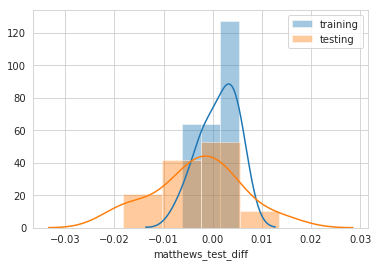

In [10]:
sns.distplot(df_all['matthews_diff'], label='training')
sns.distplot(df_all['matthews_test_diff'], label='testing')
plt.legend()

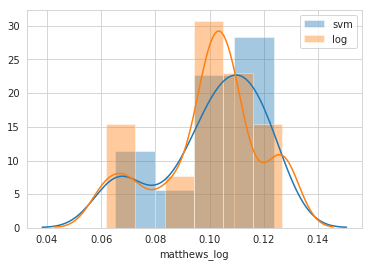

In [11]:
sns.distplot(df_all['matthews_svm'], label='svm')
sns.distplot(df_all['matthews_log'], label='log')
plt.legend()

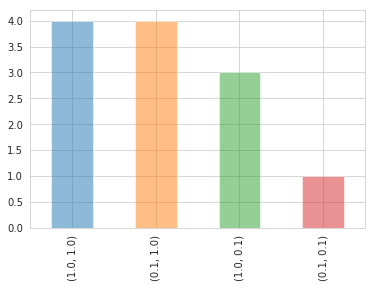

In [19]:
df_all['rs'] = list(zip(df_all['r'], df_all['s']))
df_all['rs'].value_counts().plot(kind='bar', alpha=0.5, stacked=False)

In [12]:
df_all['matthews_diff'].sum(), df_all['matthews_test_diff'].sum()

(0.013827431283122013, -0.037178379029058808)

In [18]:
df_all['matthews_diff'].median(), df_all['matthews_test_diff'].median()

(0.002030372847933351, -0.002334934119135497)

In [13]:
len(df_all[df_all['matthews_svm'] > df_all['matthews_log']][all_columns]), len(df_all[df_all['test_matthews_svm'] > df_all['test_matthews_log']]), len(df_all)

(8, 4, 12)

In [14]:
df_all[df_all['test_matthews_svm'] < df_all['test_matthews_log']][all_columns]

,matthews_svm,matthews_log,test_matthews_svm,test_matthews_log,roc_auc_svm,roc_auc_log,test_roc_auc_svm,test_roc_auc_log,stock
0,0.123792,0.126346,0.085829,0.089181,0.561264,0.562127,0.542765,0.544212,9269
1,0.120491,0.126827,0.101939,0.118561,0.559822,0.562089,0.550944,0.559265,9063
2,0.116434,0.111167,0.084095,0.091960,0.558035,0.555209,0.541974,0.545980,10166
6,0.101999,0.098597,0.108901,0.127183,0.550536,0.548357,0.554443,0.563175,9069
8,0.098229,0.099697,0.063912,0.072035,0.549003,0.549601,0.531846,0.535919,9058
9,0.086564,0.085573,0.089204,0.091787,0.543226,0.542407,0.544450,0.544762,9064
10,0.068227,0.070993,0.074703,0.076083,0.533991,0.535157,0.537046,0.537219,11244
11,0.065010,0.061754,0.078643,0.080730,0.532467,0.530758,0.539273,0.540134,9062


In [15]:
len(df_all[df_all['roc_auc_svm'] > df_all['roc_auc_log']][all_columns]), len(df_all[df_all['test_roc_auc_svm'] > df_all['test_roc_auc_log']][all_columns]), len(df_all)

(8, 4, 12)

In [16]:
df_all[df_all['test_matthews_svm'] < df_all['test_matthews_log']][all_columns]

,matthews_svm,matthews_log,test_matthews_svm,test_matthews_log,roc_auc_svm,roc_auc_log,test_roc_auc_svm,test_roc_auc_log,stock
0,0.123792,0.126346,0.085829,0.089181,0.561264,0.562127,0.542765,0.544212,9269
1,0.120491,0.126827,0.101939,0.118561,0.559822,0.562089,0.550944,0.559265,9063
2,0.116434,0.111167,0.084095,0.091960,0.558035,0.555209,0.541974,0.545980,10166
6,0.101999,0.098597,0.108901,0.127183,0.550536,0.548357,0.554443,0.563175,9069
8,0.098229,0.099697,0.063912,0.072035,0.549003,0.549601,0.531846,0.535919,9058
9,0.086564,0.085573,0.089204,0.091787,0.543226,0.542407,0.544450,0.544762,9064
10,0.068227,0.070993,0.074703,0.076083,0.533991,0.535157,0.537046,0.537219,11244
11,0.065010,0.061754,0.078643,0.080730,0.532467,0.530758,0.539273,0.540134,9062


In [17]:
df_all[df_all['test_roc_auc_svm'] < df_all['test_roc_auc_log']][all_columns]

,matthews_svm,matthews_log,test_matthews_svm,test_matthews_log,roc_auc_svm,roc_auc_log,test_roc_auc_svm,test_roc_auc_log,stock
0,0.123792,0.126346,0.085829,0.089181,0.561264,0.562127,0.542765,0.544212,9269
1,0.120491,0.126827,0.101939,0.118561,0.559822,0.562089,0.550944,0.559265,9063
2,0.116434,0.111167,0.084095,0.091960,0.558035,0.555209,0.541974,0.545980,10166
6,0.101999,0.098597,0.108901,0.127183,0.550536,0.548357,0.554443,0.563175,9069
8,0.098229,0.099697,0.063912,0.072035,0.549003,0.549601,0.531846,0.535919,9058
9,0.086564,0.085573,0.089204,0.091787,0.543226,0.542407,0.544450,0.544762,9064
10,0.068227,0.070993,0.074703,0.076083,0.533991,0.535157,0.537046,0.537219,11244
11,0.065010,0.061754,0.078643,0.080730,0.532467,0.530758,0.539273,0.540134,9062
